# Disseration Experiment 3f
# Model Build and SHAP Metric x 2  (Credit Default) November 17¶
Ciaran Finnegan November 2023

# Import Libraries + Custom Functions

## Import Libraries

In [1]:
# Import libs
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
import shap
import random

from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker


# Import libraries to build ANN model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample


# Classifier training (not used for explainability)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Import libraries for explainer metrics
from sklearn.cluster import KMeans
from scipy.spatial import distance


# Additional display libraires
import contextlib
import os
import sys
from contextlib import contextmanager


import warnings

## Custom Functions

Dataset Visualisations

In [2]:
%run ./DS_Visualisation_Functions.ipynb

Metrics

In [3]:
%run ./XAI_Metrics_Functions.ipynb

Model Evaluation Functions

In [4]:
%run ./DS_Model_Build_Evaluation_Functions.ipynb

# Data Visualisation and Exploration

## Import Data

In [5]:
ds_file_to_load = 'credit_default_data.csv'
df = pd.read_csv(ds_file_to_load)

## Data Exploration

### Dataset Structure

In [6]:
# Display the first few rows of the dataset to understand its structure
styled_dataframe(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [7]:
# Reset default Pandas display options
pd.reset_option('display.max_columns')
pd.reset_option('display.expand_frame_repr')
pd.reset_option('display.max_colwidth')
# Display the dataframe
display(df.head())

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### Generate Visualizations

In [8]:
# Set up the target and features to be visualised

sTarget_feature = 'default'
sFeature_analysis_1 = 'LIMIT_BAL'
sFeature_analysis_2 = 'AGE'
sFeature_analysis_3 = 'SEX'
sFeature3_ticklabel1 = 'Male'
sFeature3_ticklabel2 = 'Female'

#### Generate Visualizations to better understand the data distribution and relationships between features.

#### Bar and Box Plot Visualisations

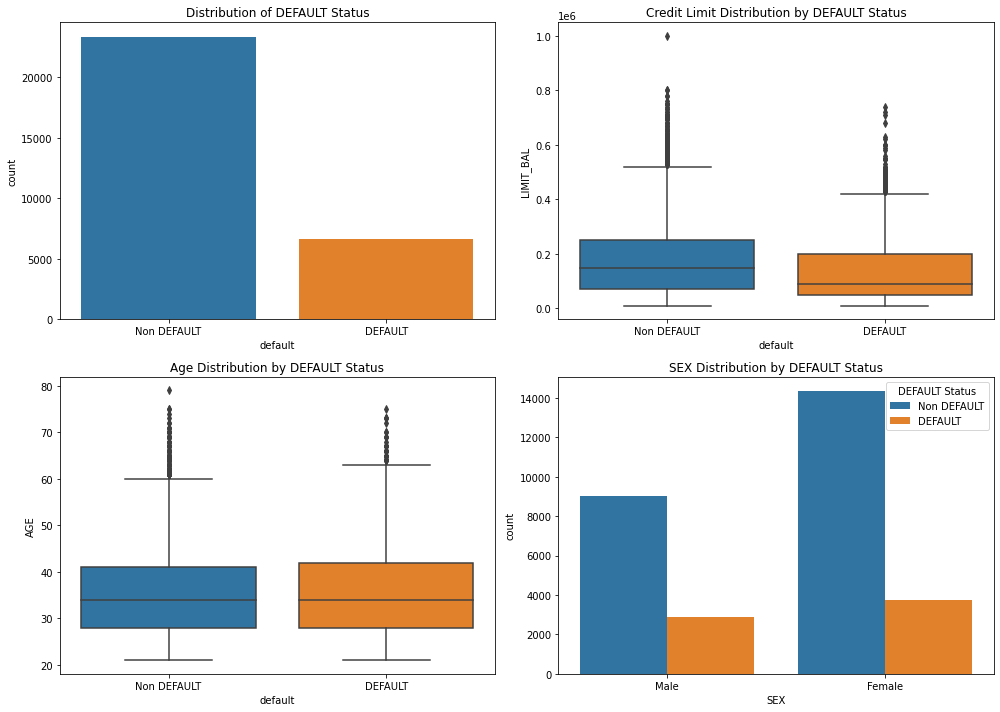

In [9]:
generate_box_plots(df, sTarget_feature, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3,
                       sFeature3_ticklabel1, 
                       sFeature3_ticklabel2)

#### Heatmap Visualisation

In [10]:
# Would need feature reduction to work effectively - or some other filtering

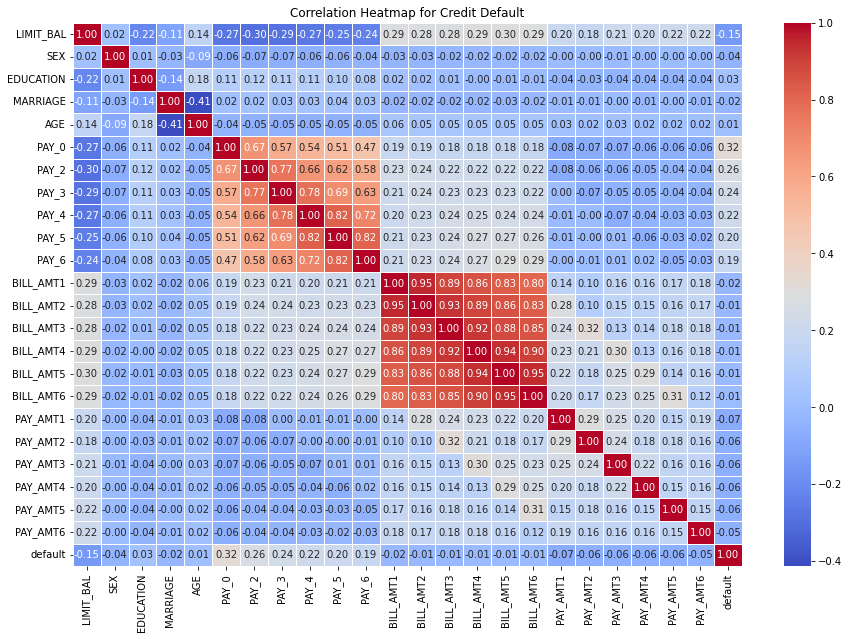

In [11]:
generate_heatmap(df, "Credit Default")

#### Distributions

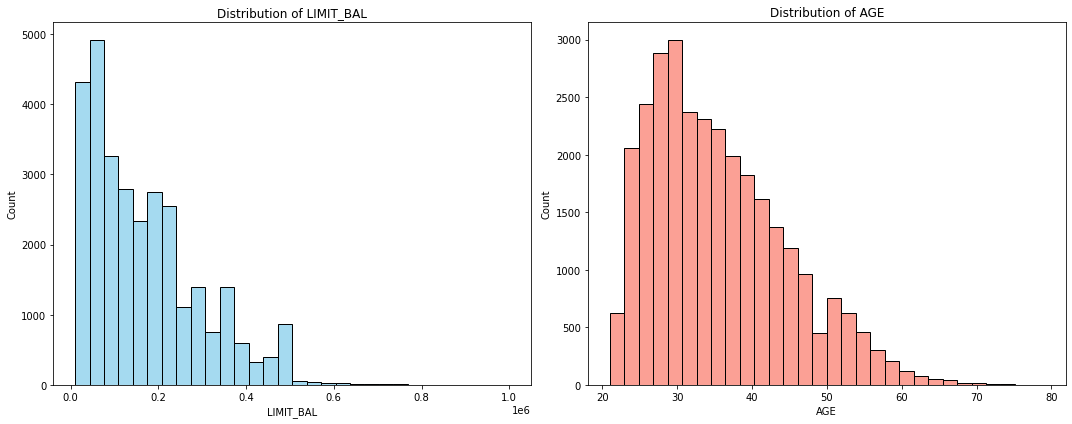

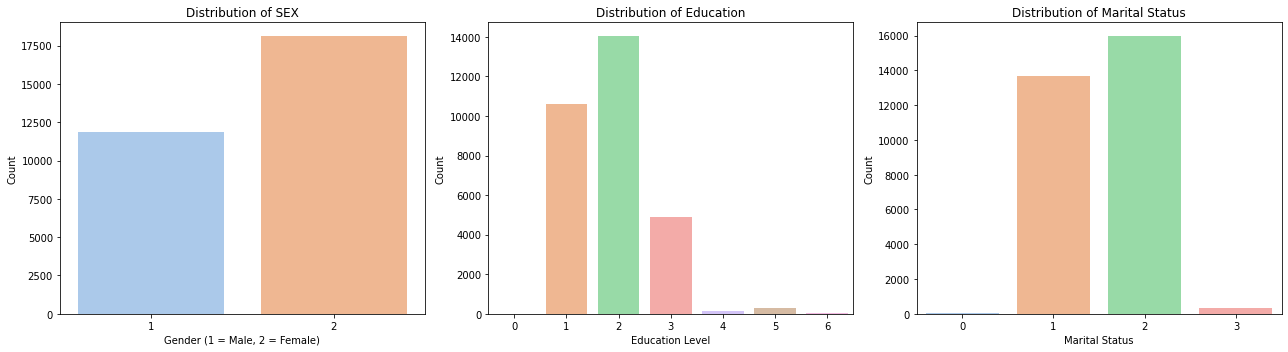

In [12]:
generate_distributions(df, 
                       sFeature_analysis_1, 
                       sFeature_analysis_2, 
                       sFeature_analysis_3)

# Feature Engineering

## Check for Missing Data

In [13]:
# Determine the threshold for missing values
threshold = 0.75 * len(df)

# Identify columns with missing values greater than the threshold
missing_columns = df.columns[df.isnull().sum() > threshold]

# Print the columns with more than 75% missing values
print("Columns with more than 75% missing values:", missing_columns)

# Drop columns with missing values greater than the threshold
df = df.drop(columns=missing_columns)

# Save or continue processing with columns removed that had high volumes of missing data

Columns with more than 75% missing values: Index([], dtype='object')


In [14]:
# Display the first few rows of the dataset to re-check structure once any columns with 
# significant amounts of missing data have been removed
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Categorical Data 

In [15]:
# List of categorical columns
cat_cols = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

In [16]:
# One-hot encode categorical variables
#df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols)

In [17]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [18]:
# Display the first few rows of the dataset to understand its structure
df_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000,24,3913,3102,689,0,0,0,0,689,...,1,0,0,0,0,0,0,0,0,0
1,120000,26,2682,1725,2682,3272,3455,3261,0,1000,...,0,0,0,1,0,0,0,0,0,0
2,90000,34,29239,14027,13559,14331,14948,15549,1518,1500,...,0,0,1,0,0,0,0,0,0,0
3,50000,37,46990,48233,49291,28314,28959,29547,2000,2019,...,0,0,1,0,0,0,0,0,0,0
4,50000,57,8617,5670,35835,20940,19146,19131,2000,36681,...,0,0,1,0,0,0,0,0,0,0


In [19]:
# display all columns
pd.set_option('display.max_columns', None)
print(df_encoded)

       LIMIT_BAL  AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  \
0          20000   24       3913       3102        689          0          0   
1         120000   26       2682       1725       2682       3272       3455   
2          90000   34      29239      14027      13559      14331      14948   
3          50000   37      46990      48233      49291      28314      28959   
4          50000   57       8617       5670      35835      20940      19146   
...          ...  ...        ...        ...        ...        ...        ...   
29995     220000   39     188948     192815     208365      88004      31237   
29996     150000   43       1683       1828       3502       8979       5190   
29997      30000   37       3565       3356       2758      20878      20582   
29998      80000   41      -1645      78379      76304      52774      11855   
29999      50000   46      47929      48905      49764      36535      32428   

       BILL_AMT6  PAY_AMT1  PAY_AMT2  P

## Downsample Majority Class

In [20]:
# Check the distribution of the target variable
target_distribution = df_encoded['default'].value_counts()

target_distribution

0    23364
1     6636
Name: default, dtype: int64

In [21]:
# Separate the majority and minority classes
df_majority = df_encoded[df_encoded['default'] == 0]
df_minority = df_encoded[df_encoded['default'] == 1]

In [22]:
# Downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                   replace=False, 
                                   n_samples=target_distribution[1], 
                                   random_state=42)

In [23]:
# Combine the downsampled majority class with the minority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

In [24]:
# Shuffle the dataset to mix the data points
df_downsampled = df_downsampled.sample(frac=1, random_state=42).reset_index(drop=True)

In [25]:
# Display the distribution of the target variable in the downsampled dataset
df_downsampled['default'].value_counts()

0    6636
1    6636
Name: default, dtype: int64

## Split Features + Target

In [26]:
# Splitting the features and target variable
X = df_downsampled.drop('default', axis=1)
y = df_downsampled['default']

## Split Data into Test/Training Datasets

In [27]:
# Splitting the data into training and testing sets
X_train_downsampled, X_test_downsampled, y_train_downsampled, y_test_downsampled = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [28]:
# Reset Indexes
X_train_downsampled = X_train_downsampled.reset_index(drop=True)
X_test_downsampled = X_test_downsampled.reset_index(drop=True)

y_train_downsampled = y_train_downsampled.reset_index(drop=True)
y_test_downsampled = y_test_downsampled.reset_index(drop=True)

In [29]:
X_test_downsampled.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,200000,27,4257,3690,4460,3190,5238,950,3690,4460,3190,5238,950,250,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,490000,30,26088,24092,24488,16995,-1527,62491,2003,2041,1092,4,64895,3003,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,20000,23,7040,7897,7622,8294,8016,9382,1128,0,800,0,1500,815,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,160000,31,50901,53859,55814,59726,61615,65939,4000,3000,5000,3000,5000,2000,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,30000,23,20958,12186,5754,5070,759,2480,1092,1109,1000,759,2480,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [30]:
X_test_downsampled.shape

(2655, 91)

In [31]:
X_test_downsampled['LIMIT_BAL']

0       200000
1       490000
2        20000
3       160000
4        30000
         ...  
2650     80000
2651     60000
2652    100000
2653     30000
2654     20000
Name: LIMIT_BAL, Length: 2655, dtype: int64

## Scale The Features

In [32]:
X_train_downsampled.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-2,PAY_0_-1,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,160000,44,0,14121,0,0,0,150,14121,0,0,0,150,790,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,230000,38,14887,23751,52698,101007,103598,150430,10000,30000,50000,4691,50000,4000,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,30000,39,9884,9586,10318,10522,11354,11022,0,1200,375,1000,0,1000,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,200000,27,3592,3622,7990,10392,7042,5692,3622,7990,6000,0,2000,5000,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,130000,38,6360,5375,5476,6931,99416,99702,1088,1189,2646,104590,3358,3314,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


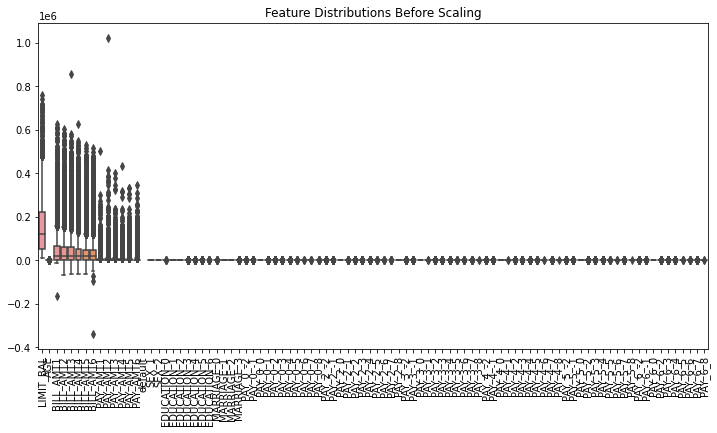

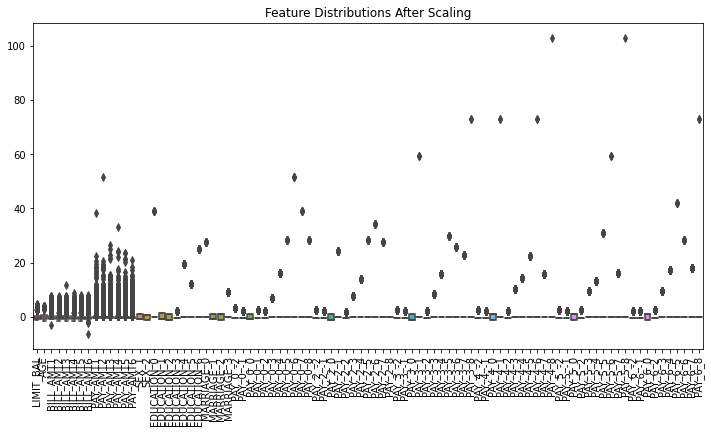

In [33]:
X_train_downsampled, X_test_downsampled = scale_the_features(X_train_downsampled, X_test_downsampled, df_downsampled)

## Basic Additional Data Exploration (Training Data)

In [34]:
# Train model Stats
print("Number of Features:", X_train_downsampled.shape[1])
print("Number Continuous Features:", X_train_downsampled.shape[1] - len(cat_cols))
print("Number Categorical Features:", len(cat_cols))
print("Number Train Examples:", X_train_downsampled.shape[0])
print("Number Positive Train Examples:", (y_train_downsampled == 1).sum())
print("Number Negative Train Examples:", (y_train_downsampled == 0).sum())

Number of Features: 91
Number Continuous Features: 82
Number Categorical Features: 9
Number Train Examples: 10617
Number Positive Train Examples: 5291
Number Negative Train Examples: 5326


# Build Model

## Set Up Hyperparameters

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

Using TensorFlow backend


In [36]:
# Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), 
                    activation='relu', input_shape=(X_train_downsampled.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_input', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    
    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [37]:
# Set up the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,#10
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

Reloading Tuner from my_dir/helloworld/tuner0.json


In [38]:
# Perform hyperparameter tuning
tuner.search(X_train_downsampled, 
             y_train_downsampled, 
             epochs=50,#50 
             validation_split=0.2, 
             verbose=1)

In [39]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [40]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units_input')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 352 and the optimal learning rate for the optimizer
is 0.0001.



## Build Neural Network (w/TensorFlow/Keras)

In [41]:
# Build the model with the best hyperparameters
model = build_model(best_hps)

In [42]:
# Train the model
history = model.fit(
    X_train_downsampled, 
    y_train_downsampled, 
    epochs=50, #50
    batch_size=32,#32 
    validation_split=0.2, 
    verbose=1
)

Epoch 1/50
266/266 [==============================] - 2s 4ms/step - loss: 0.6223 - accuracy: 0.6585 - val_loss: 0.5753 - val_accuracy: 0.7029
Epoch 2/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5846 - accuracy: 0.6943 - val_loss: 0.5708 - val_accuracy: 0.7067
Epoch 3/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5762 - accuracy: 0.6980 - val_loss: 0.5652 - val_accuracy: 0.7057
Epoch 4/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5673 - accuracy: 0.7036 - val_loss: 0.5628 - val_accuracy: 0.7062
Epoch 5/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5637 - accuracy: 0.7087 - val_loss: 0.5669 - val_accuracy: 0.7053
Epoch 6/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5607 - accuracy: 0.7133 - val_loss: 0.5626 - val_accuracy: 0.7039
Epoch 7/50
266/266 [==============================] - 1s 3ms/step - loss: 0.5604 - accuracy: 0.7124 - val_loss: 0.5621 - val_accuracy: 0.7062
Epoch 

# Evaluate Model

## Assess and Display Model Peformance

### Tabular Data

In [43]:
y_pred_funct = display_model_metrics_tabular(model, X_test_downsampled, y_test_downsampled)

83/83 [==============================] - 0s 1ms/step - loss: 0.6515 - accuracy: 0.6814


83/83 [==============================] - 0s 1ms/step


Metric,Value
Accuracy,0.681356
ROC AUC Score,0.742844
Precision (Class 0),0.654461
Recall (Class 0),0.750382
F1-Score (Class 0),0.699147
Precision (Class 1),0.716392
Recall (Class 1),0.614126
F1-Score (Class 1),0.661329


Tablular Done!


### Confusion Matrix

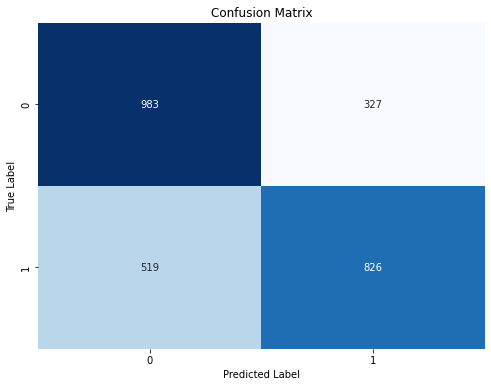

'Confusion Matrix!'

In [44]:
generate_confusion_matrix(y_test_downsampled, y_pred_funct)

# Generate Shap Values

In [45]:
# Create a SHAP explainer
explainer = shap.KernelExplainer(model.predict, shap.sample(X_train_downsampled, 100)) #100

4/4 [==============================] - 0s 2ms/step


In [46]:
X_test_downsampled

array([[ 0.36822805, -0.9135608 , -0.62861507, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [ 2.66890055, -0.59540227, -0.33395329, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-1.05977557, -1.33777218, -0.5910518 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       ...,
       [-0.42510729, -0.80750796, -0.6860735 , ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-0.98044203,  0.78328472, -0.47308451, ..., -0.0350136 ,
        -0.05583828, -0.01372635],
       [-1.05977557, -1.33777218, -0.42418342, ..., -0.0350136 ,
        -0.05583828, -0.01372635]])

In [47]:
# Extract the feature names, excluding the target variable 'default'
column_names = df_downsampled.drop('default', axis=1).columns

In [48]:
# Convert NumPy array to DataFrame
X_test_downsampled = pd.DataFrame(X_test_downsampled, columns=column_names)

In [49]:
#import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Your code that produces warnings goes here
    shap_values = explainer.shap_values(X_test_downsampled.iloc[:100,:], silent=True) #100

6757/6757 [==============================] - 8s 1ms/step


In [50]:
# Convert NumPy array to DataFrame
X_train_downsampled = pd.DataFrame(X_train_downsampled, columns=column_names)

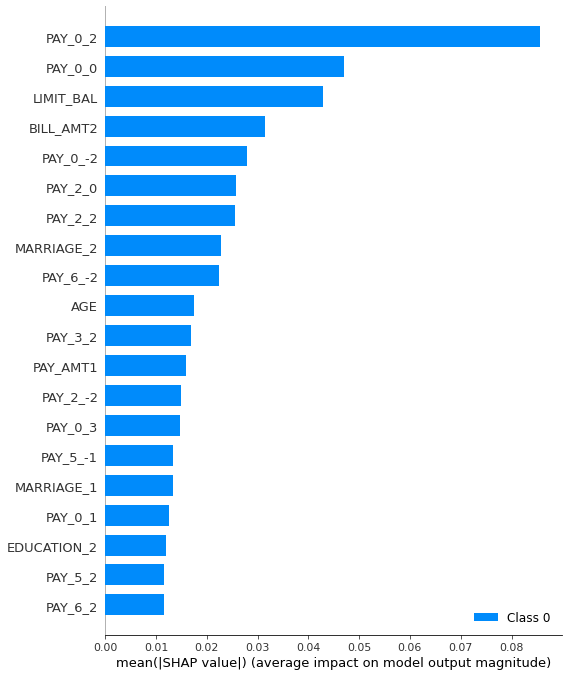

In [51]:
# Create a SHAP summary plot
shap.summary_plot(shap_values, X_test_downsampled.iloc[:100,:], feature_names=X_train_downsampled.columns)

# Prepare Data for Metric Calculations

In [52]:
import shap
import pandas as pd
import warnings

In [53]:
def generate_shap_explanations(model, data, target_column='default', 
                                output_instance_file='instances2.csv', 
                                output_shap_file='shap_values2.csv'):
    # Drop the target column from the data
    data_features = data.drop(columns=[target_column])
    
    # Select a subset of the data for explanation (first 25 instances)
    instances_to_explain = data_features.iloc[:25, :]#25
    
    # Create a SHAP explainer
    explainer = shap.KernelExplainer(model.predict, shap.sample(data_features, 100)) #100
    
    # Generate SHAP values for the instances
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # Your code that produces warnings goes here
        shap_values = explainer.shap_values(instances_to_explain)
    
    # Convert the SHAP values to a DataFrame
    if isinstance(shap_values, list):
        # For multi-class models, average the SHAP values over all classes
        shap_values = np.mean(shap_values, axis=0)
    df_shap_values = pd.DataFrame(shap_values, columns=data_features.columns)
    
    # Output the SHAP values to a csv file
    df_shap_values.to_csv(output_shap_file, index=False)
    
    # Output the instances to a csv file
    instances_to_explain.to_csv(output_instance_file, index=False)
    
    return instances_to_explain, df_shap_values

In [54]:
# Assume that `model` is your trained model and `df_encoded` is your dataframe
df_instances, df_shap_values = generate_shap_explanations(model, df_encoded)

4/4 [==============================] - 0s 2ms/step


  0%|          | 0/25 [00:00<?, ?it/s]

6732/6732 [==============================] - 8s 1ms/step


# Generate Shap Values

## Single Random Observation

In [55]:
# Select a random observation from the test dataset
random_observation = X_test_downsampled.sample(1, random_state=42)

In [56]:
# Generate SHAP values for the instances
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    # Your code that produces warnings goes here
    shap_values_random_observation = explainer.shap_values(random_observation)

  0%|          | 0/1 [00:00<?, ?it/s]

6757/6757 [==============================] - 8s 1ms/step


In [57]:
# Get the SHAP values for class 1 (default) for this observation
shap_values_observation_class1 = shap_values_random_observation[0]

In [58]:
# Convert SHAP values to a Series for easier manipulation
shap_values_series = pd.Series(shap_values_observation_class1[0], index=random_observation.columns)

In [59]:
# Sort the features based on absolute SHAP value
sorted_features = shap_values_series.abs().sort_values(ascending=False)

In [60]:
# Display the top 20 features for the random observation in an aesthetically pleasing tabular format
top_20_features_observation = sorted_features.head(20)
top_20_features_df_observation = pd.DataFrame({'Feature': top_20_features_observation.index, 
                                               'SHAP Value': top_20_features_observation.values})

In [61]:
# Display the index (row number) of the selected observation
print(f"Selected Row Number from Test Data: {random_observation.index[0]}")

Selected Row Number from Test Data: 831


In [62]:
# Display the SHAP values for the top 20 features of the observation
print("\nTop 20 Features and Their SHAP Values:")
display(HTML(xai_styles + top_20_features_df_observation.to_html(index=False)))


Top 20 Features and Their SHAP Values:


Feature,SHAP Value
PAY_6_-2,0.105697
PAY_0_2,0.058720
PAY_2_0,0.056435
AGE,0.047326
BILL_AMT2,0.045413
PAY_0_-1,0.044098
PAY_2_-1,0.039414
PAY_0_0,0.035486
LIMIT_BAL,0.033558
PAY_6_0,0.033539


# Generate XAI Metrics 

## Identity

#### Run a Basic Test First

In [63]:
# Select two random instances from the SHAP value dataframe
df_xai_numerical = df_shap_values

random_indices = np.random.choice(df_xai_numerical.index, size=2, replace=False)
instance_1 = df_xai_numerical.iloc[random_indices[0]]
instance_2 = df_xai_numerical.iloc[random_indices[1]]

# Compute the Euclidean distance between the selected instances - uses custom project function
distance = get_euclidean_distance(instance_1, instance_2)
print(f"Euclidean distance between instance {random_indices[0]} and instance {random_indices[1]}: {distance:.4f}")


Calculating Euclidean distance...


Euclidean distance between instance 4 and instance 2: 0.1640


#### Retrieve Identity Score

In [64]:
from scipy.spatial import distance

In [65]:
SHAP_Identity_Metric = get_identity_metric(df_instances, df_shap_values, "SHAP")

Instance 0:   Current matches: 1
	Closest feature instance: 9 (Distance: 23644.2441)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 1:   Current matches: 2
	Closest feature instance: 21 (Distance: 6806.8131)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 2:   Current matches: 3
	Closest feature instance: 24 (Distance: 32987.2902)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 3:   Current matches: 3
	Closest feature instance: 5 (Distance: 26617.4049)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 4:   Current matches: 3
	Closest feature instance: 16 (Distance: 54283.1463)
	Closest SHAP instance: {closest_xai_idx} (Distance: {xai_distances[closest_xai_idx]:.4f})
Instance 5:   Current matches: 3
	Closest feature instance: 3 (Distance: 26617.4049)
	Closest SHAP instance: {closest_

#### Display Identity Score Metric

In [66]:
SHAP_Identity_Metric

32.0

In [67]:
SHAP_Identity_Number = "{:.2f}%".format(SHAP_Identity_Metric)

In [68]:
display_text("SHAP Identity Metric Score: " + SHAP_Identity_Number)

## Stability

### Invoke Stability Metric Function

#### Retrieve Stability Score

In [69]:
SHAP_Stability_Metric = get_stability_metric_y(df_shap_values, y_test_downsampled, 'SHAP')

Number of Instances in Cluster '0': 0
Number of Instances in Cluster '1': 0

For Class '0':
Total Instances: 12
Matching Cluster '0' Instances: 0

For Class '1':
Total Instances: 13
Matching Cluster '1' Instances: 0


This is the function in XAI_METRICS_FUNCTIONS -- STABILITY -- SHAP



Percentage of matches: 0.00%   0.0 Matches of 25 Entries


#### Display Stability Score Metric

In [70]:
SHAP_Stability_Metric

0.0

In [71]:
SHAP_Stability_Number = "{:.2f}%".format(SHAP_Stability_Metric)

In [72]:
display_text("SHAP Stability Metric Score: " + SHAP_Stability_Number)

## Seperability

In [231]:
%run ./XAI_Metrics_Functions.ipynb

### Invoke Seperability Metric Function

#### Retrieve Seperability Score

In [232]:
SHAP_Seperability_Metric = get_seperability_metric(df_instances, df_shap_values, "SHAP")

In [233]:
SHAP_Seperability_Metric_Y = get_seperability_metric_y(df_instances, df_shap_values, "SHAP")

#### Display Seperability Score Metric

In [234]:
SHAP_Seperability_Metric

100.0

In [235]:
SHAP_Seperability_Metric_Y

100.0

In [236]:
SHAP_Seperability_Number = "{:.2f}%".format(SHAP_Seperability_Metric_Y)

In [237]:
display_text("SHAP Seperability Metric Score: " + SHAP_Seperability_Number)

## Similarity

In [238]:
%run ./XAI_Metrics_Functions.ipynb

### Invoke Similarity Metric Function

#### Retrieve Similarity Score

In [239]:
SHAP_Similarity_Metric = get_similarity_metric(df_instances, df_shap_values, "SHAP", use_dbscan=False)

In [240]:
SHAP_Similarity_Number = "{:6.2f}".format(SHAP_Similarity_Metric)

In [241]:
display_text("SHAP Similarity Metric Value: " + SHAP_Similarity_Number)